In [1]:
import numpy as np
import os,sys,glob,json,pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

import scipy.stats as stats

import healpy as hp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

import hasasia.sensitivity as hassen
import hasasia.sim as hassim
import hasasia.skymap as hassky

In [2]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

In [3]:
top_dir = '/Users/andrewkaiser/Documents/GradSchool/Research/nanograv'
save_dir = top_dir + '/Figures/'

pta_sim_dir = top_dir + '/pta_sim/pta_sim/'
sys.path.insert(0,pta_sim_dir)
import noise

In [4]:
noise_11yr_dir = top_dir + '/NANOGrav/BackgroundInjections/nano11/noisefiles_new/'
noise_11yr = sorted(glob.glob(noise_11yr_dir+'*.txt'))
print(len(noise_11yr))

45


In [5]:
psrlist_11yr_file = top_dir + '/NANOGrav/BackgroundInjections/nano11/psrlist_Tg3yr.txt'
encoding = 'utf-8'
psr_list_bytes = np.loadtxt(psrlist_11yr_file,dtype='S42')
psr_list = []
for psr in psr_list_bytes:
    psr_list.append(psr.decode(encoding))
print(len(psr_list))

34


In [6]:
def get_psrname(file,name_sep='_'):
    return file.split('/')[-1].split(name_sep)[0]

In [7]:
noise_11yr = [f for f in noise_11yr if get_psrname(f,name_sep='_') in psr_list]
len(noise_11yr)

34

In [8]:
noiseparams_11yr = {}
for nf in noise_11yr:
    noiseparams_11yr.update(noise.get_noise_from_file(nf))

In [9]:
rn_amps=[]
rn_gammas=[]
for psr in psr_list:
    rn_amps.append(10**noiseparams_11yr[psr+'_red_noise_log10_A'])
    rn_gammas.append(noiseparams_11yr[psr+'_red_noise_gamma'])
rn_alphas=(np.array(rn_gammas)-3)/(-2)
rn_amps = np.array(rn_amps)

In [10]:
print(rn_alphas)
print(rn_amps)

[ 0.237595   -1.849685    1.45519845  1.4551923   1.421065    1.4551756
  1.1062485   1.059827   -0.44214     0.30179     0.569165    0.926505
 -0.31684     1.0329505   0.840565    0.288385    1.132205    1.016138
  0.84825     0.81664     1.45505955  0.55882     0.571785    0.823545
  0.47733     0.67955     0.848205    0.43367     0.69968     1.47221215
  0.393835    0.80089     0.83438     1.45518835]
[3.56287019e-15 1.06954731e-14 7.02425064e-20 3.58674086e-14
 1.88625325e-16 1.88451674e-18 3.90391183e-14 3.30597831e-17
 1.01531312e-14 3.87971657e-14 1.23708631e-16 7.10886063e-14
 1.57688492e-14 2.61697757e-17 1.53744646e-20 5.77829886e-14
 1.31734643e-20 2.11787342e-13 2.04550243e-13 1.31825674e-14
 7.77320283e-16 6.60541335e-14 2.60075834e-16 4.34310171e-14
 5.62211856e-14 1.44410908e-16 5.72796031e-13 2.43781082e-17
 2.79190091e-20 3.25087297e-13 5.75970181e-13 6.23591232e-13
 1.55274450e-13 5.31496000e-14]


In [11]:
coord = []
c_1713 = []
c_0613 = []
for i in range(len(psr_list)):
    if 'J' in psr_list[i]:
        if '+' in psr_list[i]:
            #if '1713' not in psr_list[i]:
            a = psr_list[i].split('J')[1]
            b = a.split('+')[0]
            c = a.split('+')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('+'+c[0:2]+'d'+c[2:4]+'m00s')
            coord.append(SkyCoord(ra, dec, frame='icrs'))

        else:
            a = psr_list[i].split('J')[1]
            b = a.split('-')[0]
            c = a.split('-')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('-'+c[0:2]+'d'+c[2:4]+'m00s')            
            coord.append(SkyCoord(ra, dec, frame='icrs'))
    else:
        if '+' in psr_list[i]:
            a = psr_list[i].split('B')[1]
            b = a.split('+')[0]
            c = a.split('+')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('+'+c[0:2]+'d'+'00m00s')
            coord.append(SkyCoord(ra, dec, frame='fk4'))
        else:
            a = psr_list[i].split('B')[1]
            b = a.split('-')[0]
            c = a.split('-')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('-'+c[0:2]+'d'+'00m00s')
            coord.append(SkyCoord(ra, dec, frame='fk4'))

In [12]:
phis = np.array([c.ra.radian for c in coord])
thetas = np.array([np.pi/2 - c.dec.radian for c in coord])

In [13]:
sigmas=np.array([0.361, 0.691, 0.454,
                 0.422, 0.178, 1.07,
                 0.323, 0.672, 0.23,
                 0.199, 0.426, 3.31,
                 0.108, 0.52, 0.128,
                 0.842, 3.59, 0.239,
                 0.809, 3.65, 0.148,
                 0.544, 0.322, 0.229,
                 0.57, 0.352, 0.377,
                 0.257, 0.11, 0.12,
                 0.968, 1.33, 1.07,
                 0.271])*u.us.to('s')

In [14]:
header = 'Row order: phis, thetas, sigmas, RN_amps, RN_alphas'
#np.savetxt(top_dir + '/params_11yr.txt',[phi,theta,sigmas.value,amps,alphas],header=header)

In [15]:
T_obs = 11.5*u.yr#[11.5,14.5,20.]*u.yr#,25.,30.]*u.yr
sigma = 100*u.ns.to('s')*u.s # 100 ns
cadence = 23/u.yr #number of observations/yr
f_min = cadence.to('1/s')/2. #nyquist frequency

In [16]:
#Use the healpy functions to get the sky coordinates
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [17]:
def make_hasasia_sensitivity_thing(T_obs,cadence,sigmas,phis,thetas,rn_amps,rn_alphas,SkyAvg=False):
    Tspan = T_obs.to('s') #Tspan in seconds
    #Simulate a set of identical pulsars, with different sky positions.
    freqs = np.logspace(np.log10(1/(5*Tspan.value)),np.log10(f_min.value),500)

    psrs = hassim.sim_pta(timespan=T_obs.value, cad=cadence.value, sigma=sigmas,
                    phi=phis, theta=thetas, A_rn = rn_amps, alpha=rn_alphas, freqs = freqs)
    spectra = []
    for p in psrs:
        sp = hassen.Spectrum(p, freqs=freqs)
        sp.NcalInv
        spectra.append(sp)
        
    if SkyAvg:
        #make deterministic pta
        return hassen.DeterSensitivityCurve(spectra)
    else:
        return hassky.SkySensitivity(spectra,theta_gw, phi_gw)

In [18]:
sky_map = make_hasasia_sensitivity_thing(T_obs,cadence,sigmas,phis,thetas,rn_amps,rn_alphas)

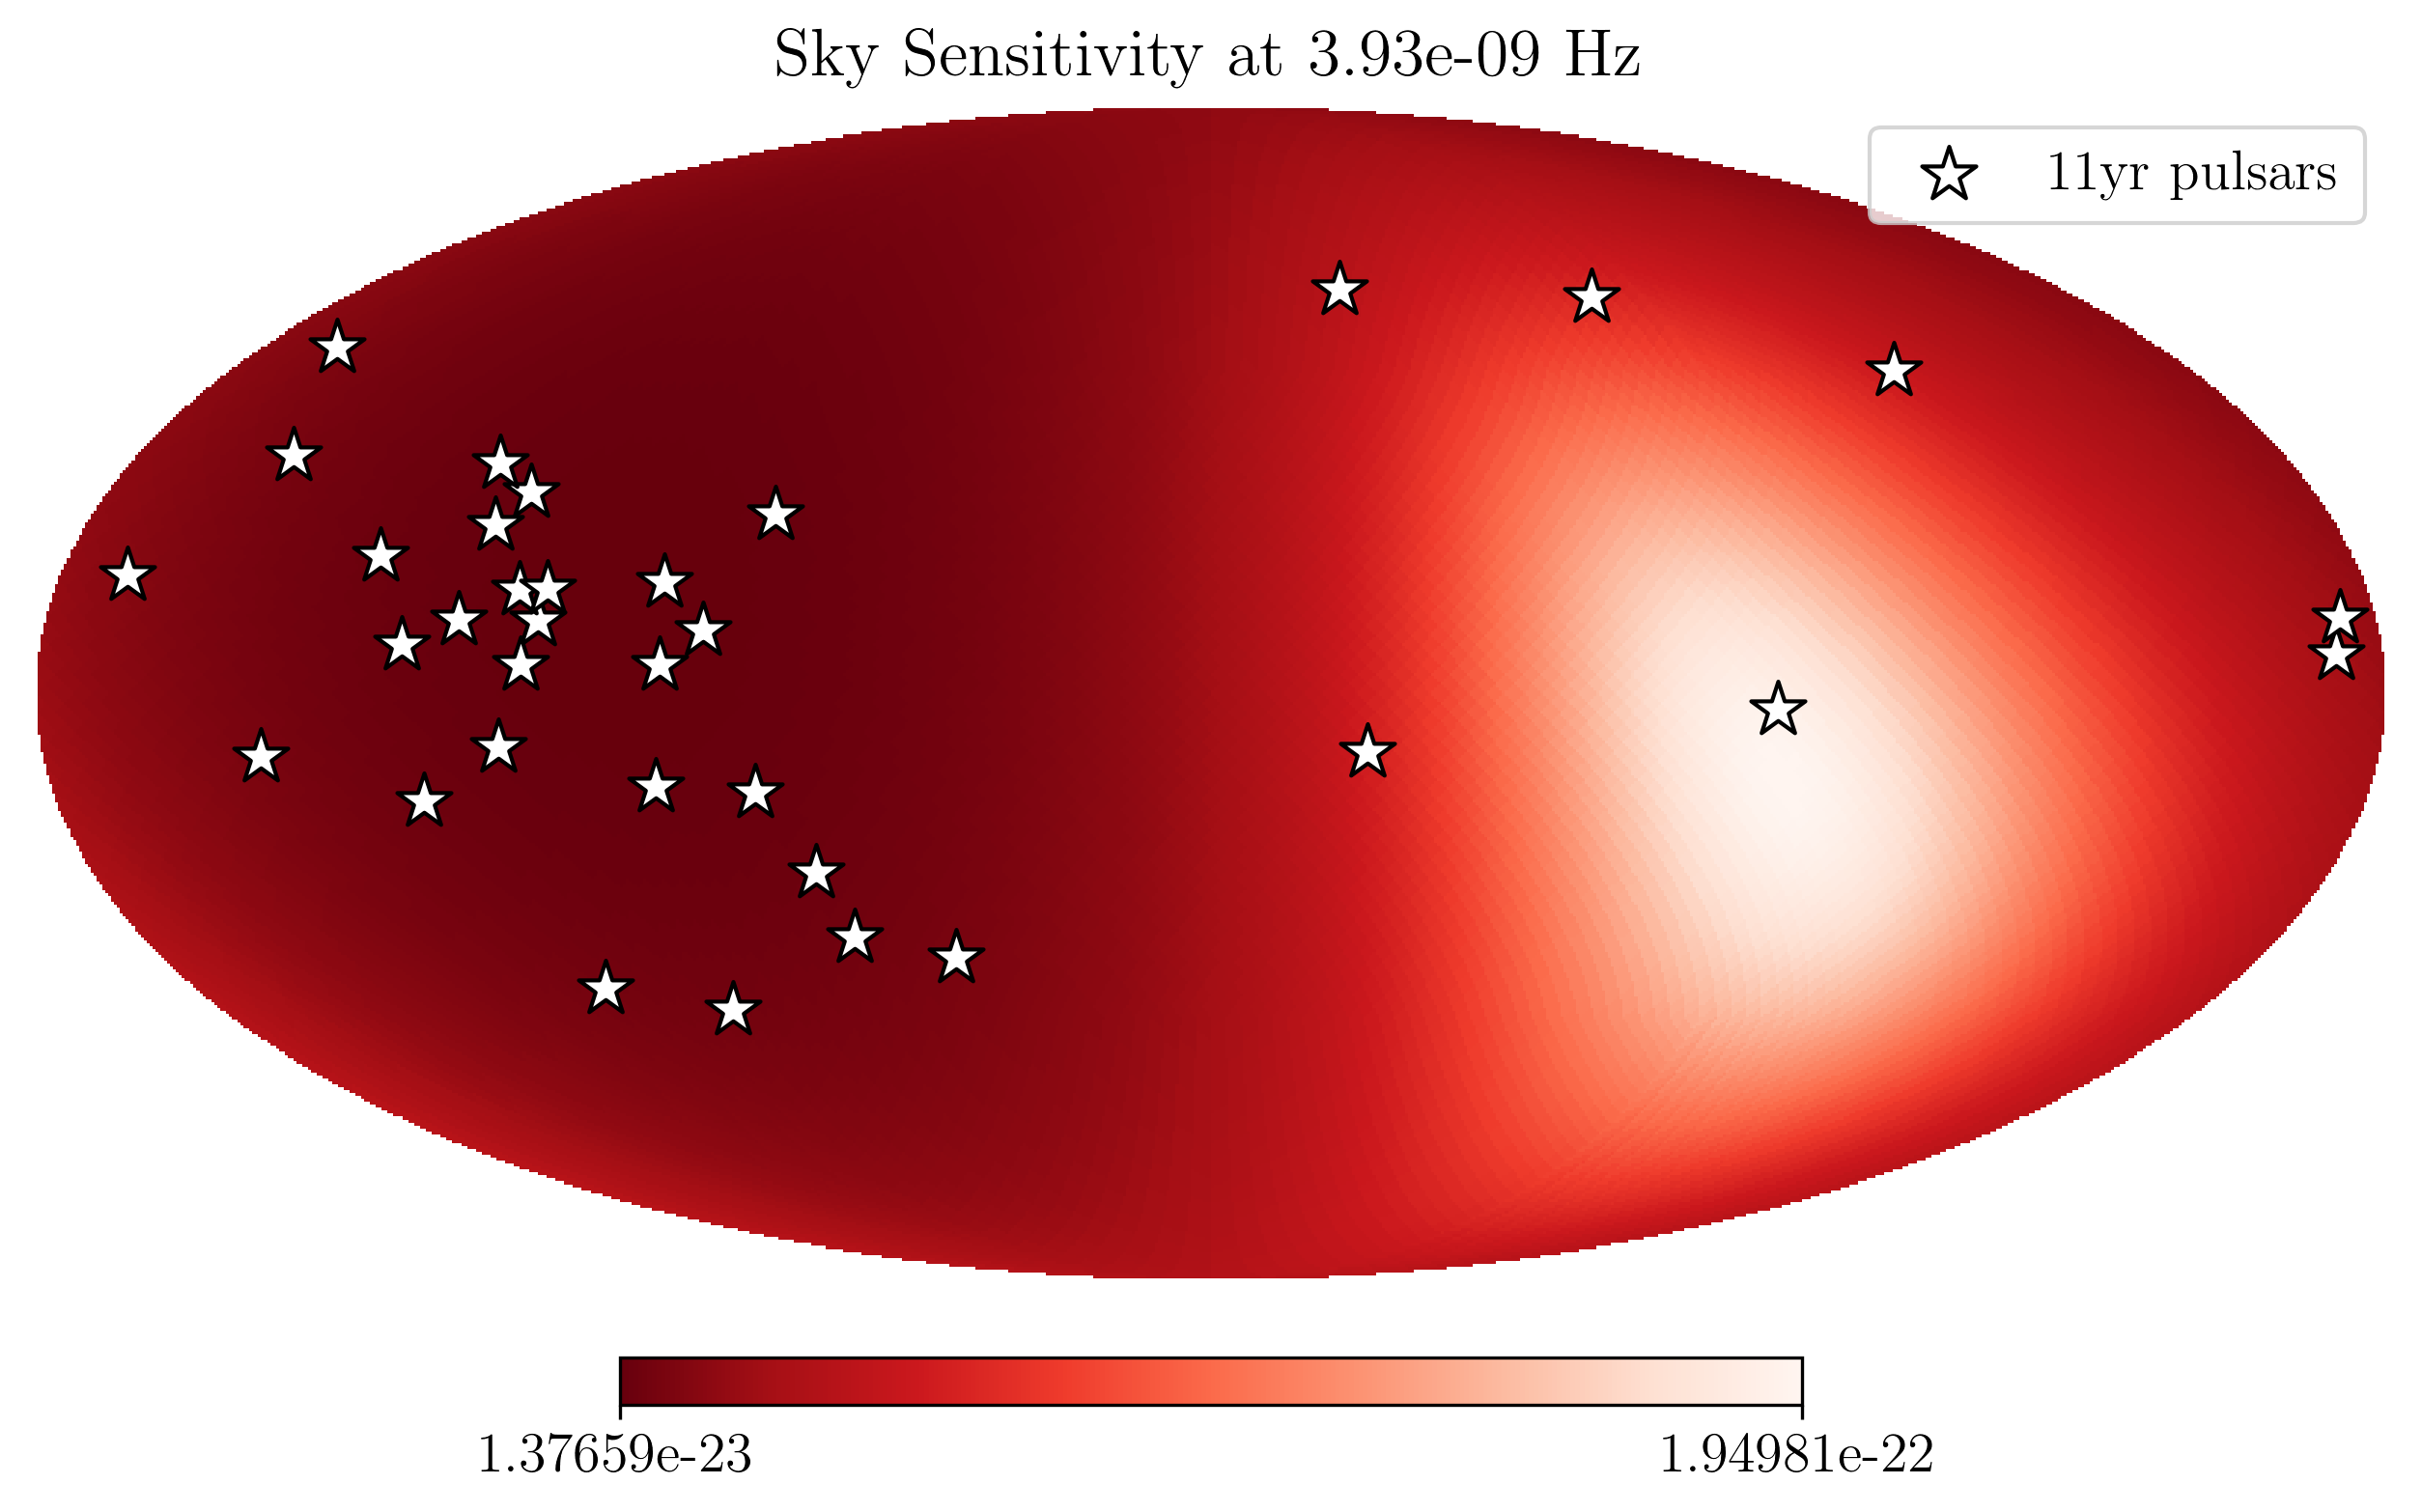

In [50]:
idxs = np.unravel_index(np.argmin(sky_map.S_effSky, axis=None), sky_map.S_effSky.shape)
idx = idxs[0]
hp.mollview(sky_map.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(sky_map.freqs[idx]),
            cmap='Reds_r', rot=180)
hp.visufunc.projscatter(sky_map.thetas,sky_map.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200,label=r'11yr pulsars')
plt.legend()
plt.show()

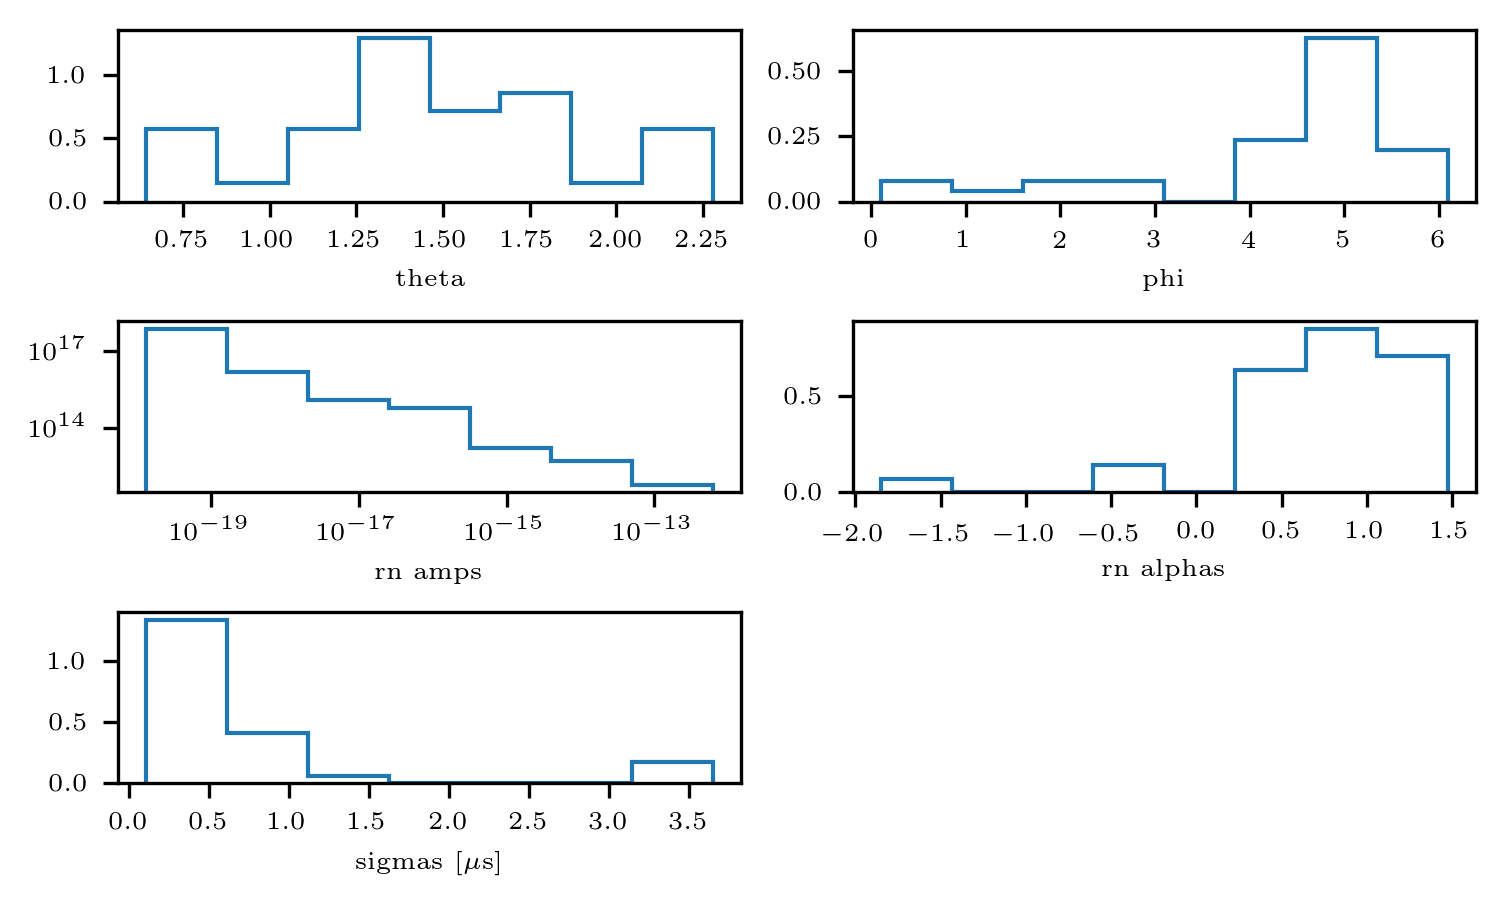

In [20]:
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':6})
fig,axes = plt.subplots(3,2)
fig.delaxes(axes[2,1])
nbins = 8
axes[0,0].hist(thetas, histtype='step', density= True, bins = nbins)
axes[0,0].set_xlabel(r'theta')

axes[0,1].hist(phis, histtype='step', density= True, bins=nbins)
axes[0,1].set_xlabel(r'phi')

axes[1,1].hist(rn_alphas, histtype='step', density= True, bins=nbins)
axes[1,1].set_xlabel(r'rn alphas')

axes[1,0].hist(rn_amps, histtype='step', density= True,
         bins=np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),nbins))
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].set_xlabel(r'rn amps')

sigmas_plt = sigmas/u.us.to('s')
axes[2,0].hist(sigmas_plt, histtype='step', density= True,
         bins=np.linspace(min(sigmas_plt),max(sigmas_plt),nbins))
axes[2,0].set_xlabel(r'sigmas [$\mu$s]')
fig.tight_layout()
plt.show()

In [21]:
nbins = 8
#Add non-zero probability of picking 0 and pi
new_thetas = np.append(thetas,
                       np.linspace(0.,np.pi,nbins))
new_phis = np.append(phis,
                     np.linspace(0.,2*np.pi,nbins))
#add non-zero probability in middle of alphas and amps
new_rn_alphas = np.append(rn_alphas,
                          np.linspace(min(rn_alphas),max(rn_alphas),nbins))
new_rn_amps = np.append(rn_amps,
                        np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),nbins))
new_sigmas = np.append(sigmas,
                       np.linspace(min(sigmas),max(sigmas),nbins))


phi_hist = np.histogram(new_phis, bins=nbins,density=True)
theta_hist = np.histogram(new_thetas, bins=nbins,density=True)
alpha_hist = np.histogram(new_rn_alphas, bins=nbins,density=True)
rn_amp_hist = np.histogram(new_rn_amps,
                           bins=np.logspace(min(np.log10(new_rn_amps)),max(np.log10(new_rn_amps)),nbins),
                           density=True)
sigma_hist = np.histogram(new_sigmas, bins=nbins,density=True)

phi_dist = stats.rv_histogram(phi_hist)
theta_dist = stats.rv_histogram(theta_hist)
alpha_dist = stats.rv_histogram(alpha_hist)
rn_amp_dist = stats.rv_histogram(rn_amp_hist)
sigma_dist = stats.rv_histogram(sigma_hist)

In [22]:
print(np.log10(rn_amps))
print(np.log10(new_rn_amps))

[-14.4482 -13.9708 -19.1534 -13.4453 -15.7244 -17.7248 -13.4085 -16.4807
 -13.9934 -13.4112 -15.9076 -13.1482 -13.8022 -16.5822 -19.8132 -13.2382
 -19.8803 -12.6741 -12.6892 -13.88   -15.1094 -13.1801 -15.5849 -13.3622
 -13.2501 -15.8404 -12.242  -16.613  -19.5541 -12.488  -12.2396 -12.2051
 -12.8089 -13.2745]
[-14.4482     -13.9708     -19.1534     -13.4453     -15.7244
 -17.7248     -13.4085     -16.4807     -13.9934     -13.4112
 -15.9076     -13.1482     -13.8022     -16.5822     -19.8132
 -13.2382     -19.8803     -12.6741     -12.6892     -13.88
 -15.1094     -13.1801     -15.5849     -13.3622     -13.2501
 -15.8404     -12.242      -16.613      -19.5541     -12.488
 -12.2396     -12.2051     -12.8089     -13.2745     -19.8803
 -18.78384286 -17.68738571 -16.59092857 -15.49447143 -14.39801429
 -13.30155714 -12.2051    ]


In [23]:
t = np.linspace(0,np.pi,50)
p = np.linspace(0,2*np.pi,50)
a = np.linspace(min(rn_alphas),max(rn_alphas),50)
r = np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),50)
s = np.linspace(min(sigmas_plt),max(sigmas_plt),50)

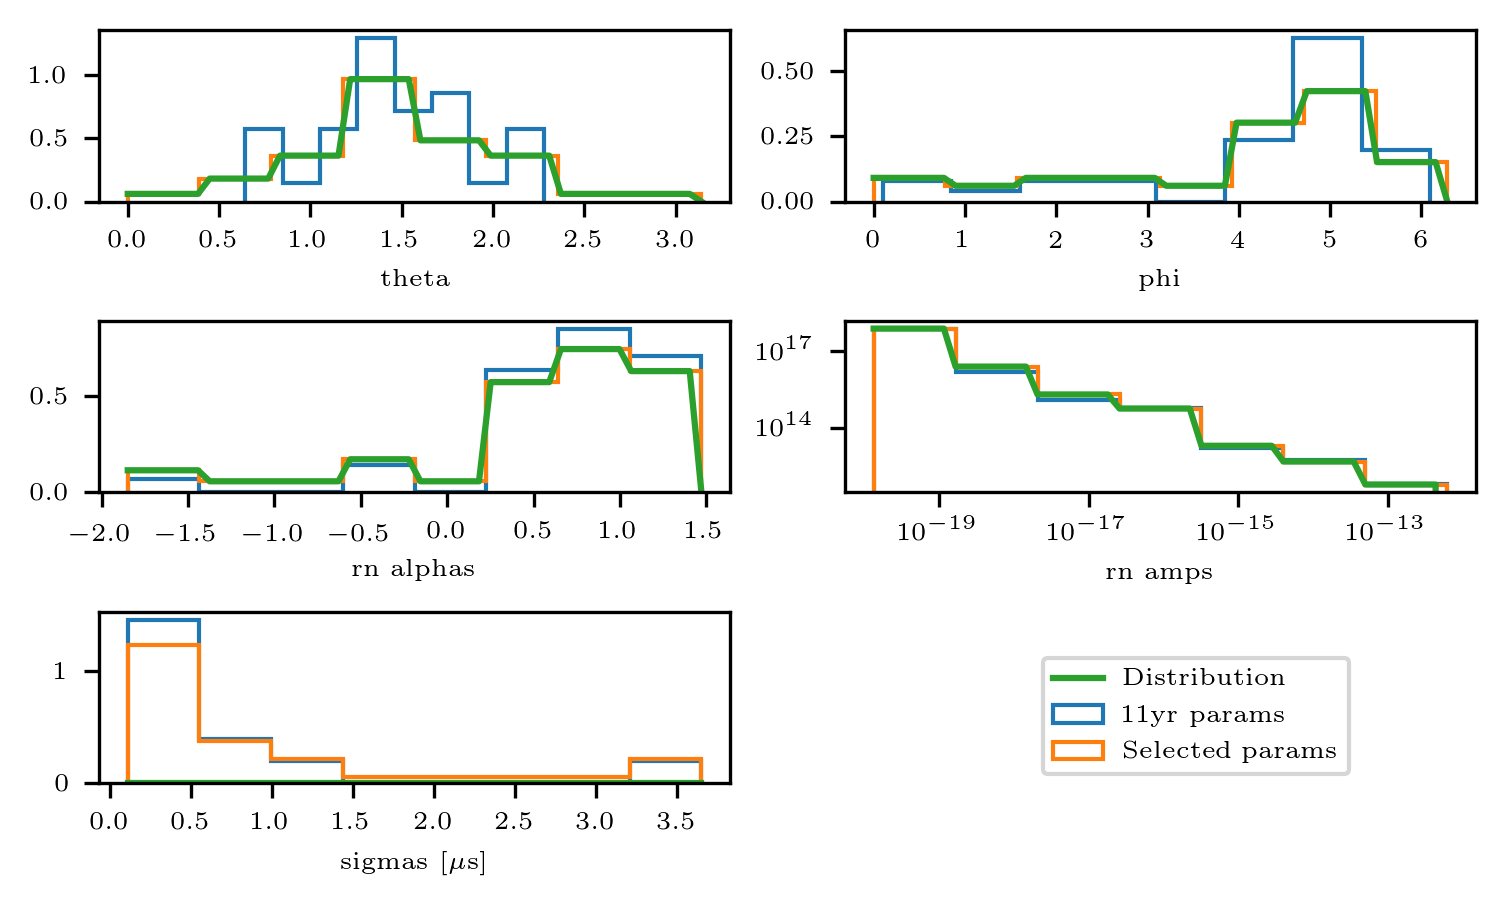

In [58]:
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':6})
fig,axes = plt.subplots(3,2)
fig.delaxes(axes[2,1])
axes[0,0].hist(thetas, histtype='step', density= True, bins=nbins,label=r'11yr params')
axes[0,0].hist(new_thetas, histtype='step', density= True, bins=nbins,label=r'Selected params')
axes[0,0].plot(t,theta_dist.pdf(t),label=r'Distribution')
axes[0,0].set_xlabel(r'theta')

axes[0,1].hist(phis, histtype='step', density= True, bins=nbins,label=r'11yr params')
axes[0,1].hist(new_phis, histtype='step', density= True, bins=nbins,label=r'Selected params')
axes[0,1].plot(p,phi_dist.pdf(p),label=r'Distribution')
axes[0,1].set_xlabel(r'phi')

sigmas_plt = sigmas/u.us.to('s')
new_sigmas_plt = new_sigmas/u.us.to('s')
sigma_dist_plt = sigma_dist.pdf(s)/u.us.to('s')
axes[2,0].hist(sigmas_plt, histtype='step', density= True,
         bins=nbins,label=r'11yr params')
axes[2,0].hist(new_sigmas_plt, histtype='step', density= True,
         bins=nbins,label=r'Selected params')
axes[2,0].plot(s,sigma_dist_plt,label=r'Distribution')
axes[2,0].set_xlabel(r'sigmas [$\mu$s]')

axes[1,0].hist(rn_alphas, histtype='step', density= True, bins=nbins,label=r'11yr params')
axes[1,0].hist(new_rn_alphas, histtype='step', density= True, bins=nbins,label=r'Selected params')
axes[1,0].plot(a,alpha_dist.pdf(a),label=r'Distribution')
axes[1,0].set_xlabel(r'rn alphas')

axes[1,1].hist(rn_amps, histtype='step', density= True,
         bins=np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),nbins),label=r'11yr params')
axes[1,1].hist(new_rn_amps, histtype='step', density= True,
         bins=np.logspace(min(np.log10(new_rn_amps)),max(np.log10(new_rn_amps)),nbins),label=r'Selected params')
axes[1,1].plot(r,rn_amp_dist.pdf(r),label=r'Distribution')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_xlabel(r'rn amps')
fig.tight_layout()
plt.legend(bbox_to_anchor=(2, .8))
plt.show()

In [25]:
N_p = 200
theta_draws_1 = theta_dist.rvs(size=N_p)
phi_draws_1 = phi_dist.rvs(size=N_p)
rn_amp_draws_1 = rn_amp_dist.rvs(size=N_p)
rn_alpha_draws_1 = alpha_dist.rvs(size=N_p)
sigma_draws_1 = sigma_dist.rvs(size=N_p)

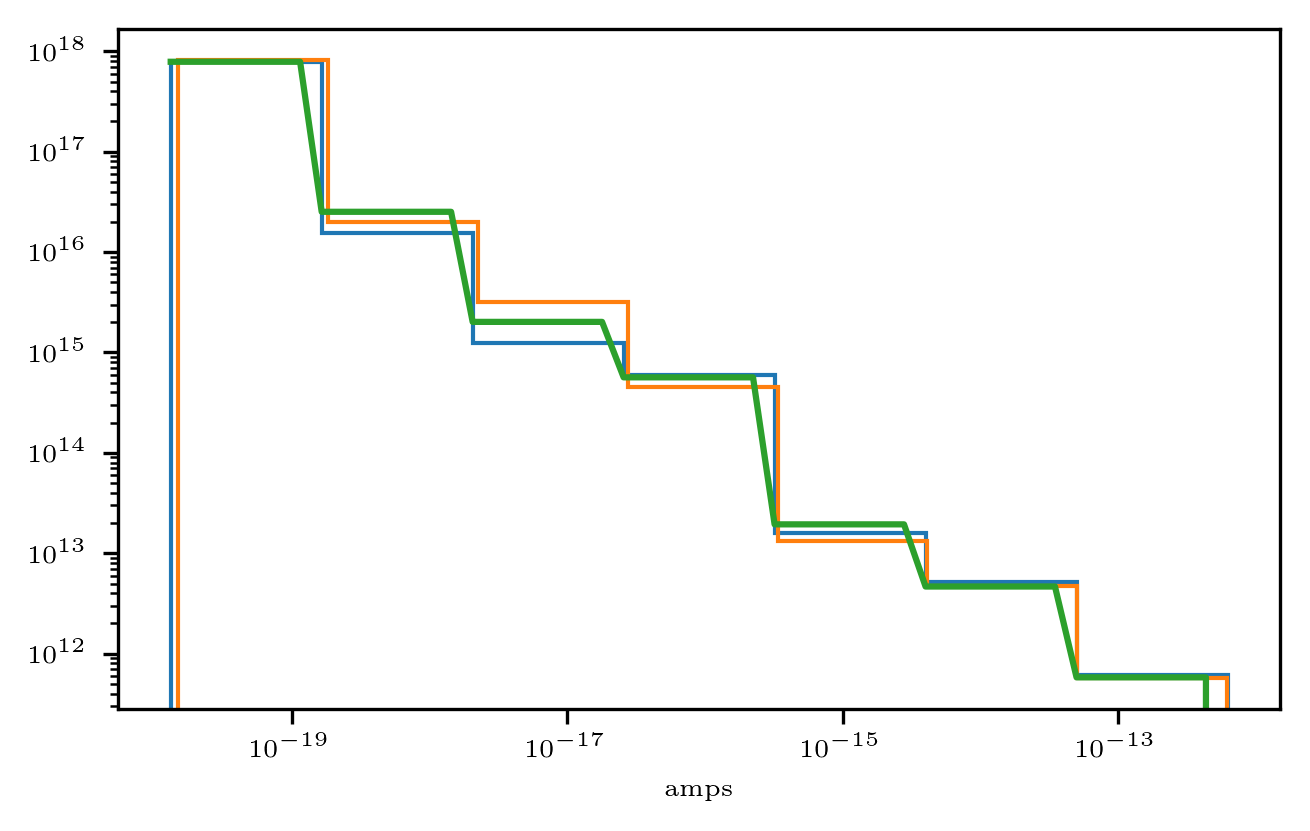

In [26]:
plt.figure()
plt.hist(rn_amps, histtype='step', density= True,
         bins=np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),nbins))
plt.hist(rn_amp_draws_1, histtype='step', density= True,
         bins=np.logspace(min(np.log10(rn_amp_draws_1)),max(np.log10(rn_amp_draws_1)),nbins))
plt.plot(r,rn_amp_dist.pdf(r))
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'amps')
plt.show()

In [27]:
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

In [28]:
new_sky_map = make_hasasia_sensitivity_thing(T_obs,cadence,
                                             sigma_draws_1,phi_draws_1,
                                             theta_draws_1,rn_amp_draws_1,
                                             rn_alpha_draws_1)

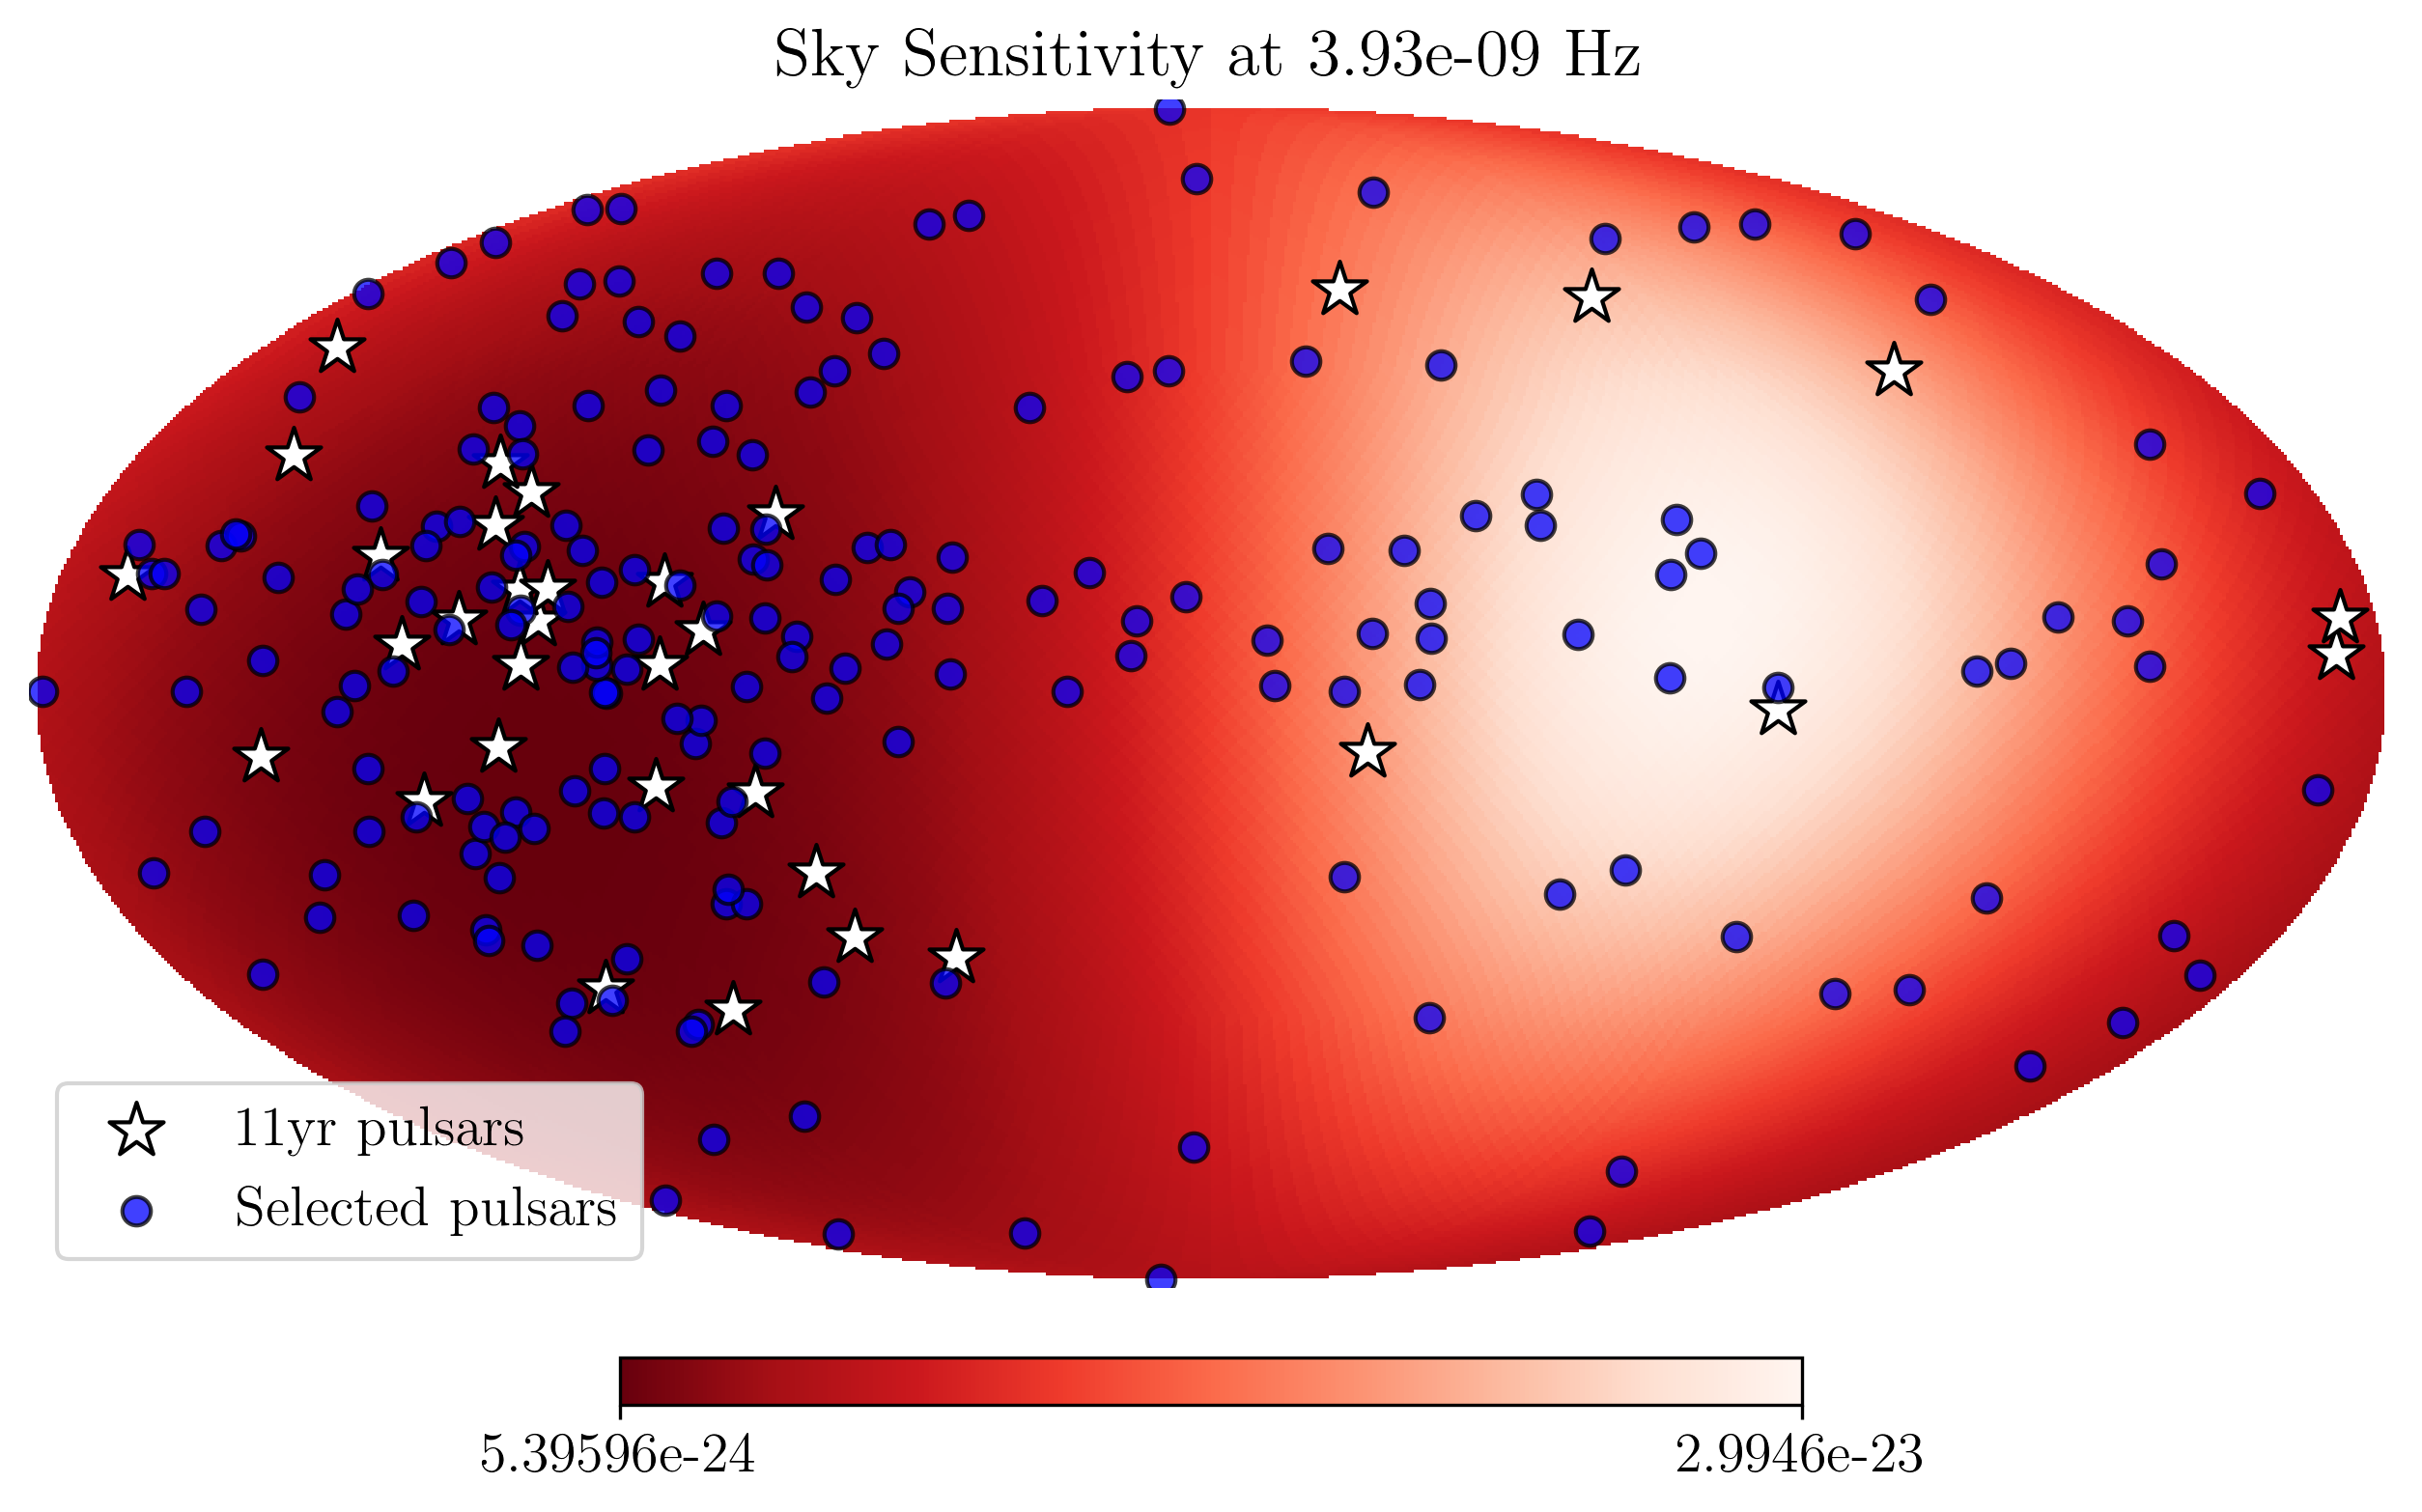

In [49]:
idxs = np.unravel_index(np.argmin(new_sky_map.S_effSky, axis=None), new_sky_map.S_effSky.shape)
idx = idxs[0]
hp.mollview(new_sky_map.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(new_sky_map.freqs[idx]),
            cmap='Reds_r', rot=180)
hp.visufunc.projscatter(sky_map.thetas,sky_map.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200,label=r'11yr pulsars')
hp.visufunc.projscatter(new_sky_map.thetas,new_sky_map.phis,
                        marker='.',color='blue',
                        edgecolors='k',s=200,label=r'Selected pulsars',alpha=.75)
plt.legend()
plt.show()

In [30]:
N_p = 14
if N_p > len(noise_11yr):
    N_added_p = N_p - len(noise_11yr)
    theta_draws = theta_dist.rvs(size=N_added_p)
    phi_draws = phi_dist.rvs(size=N_added_p)
    rn_amp_draws = rn_amp_dist.rvs(size=N_added_p)
    alpha_draws = alpha_dist.rvs(size=N_added_p)
    sigma_draws = sigma_dist.rvs(size=N_added_p)
    
    new_added_thetas = np.append(thetas,theta_draws)
    new_added_phis = np.append(phis,phi_draws)
    new_added_rn_amps = np.append(rn_amps,rn_amp_draws)
    new_added_alphas = np.append(rn_alphas,alpha_draws)
    new_added_sigmas = np.append(sigmas,sigma_draws)
else:
    new_added_thetas = thetas[:N_p]
    new_added_phis = phis[:N_p]
    new_added_rn_amps = rn_amps[:N_p]
    new_added_rn_alphas = rn_alphas[:N_p]
    new_added_sigmas = sigmas[:N_p]

In [31]:
new_added_sky_map = make_hasasia_sensitivity_thing(T_obs,cadence,
                                                   new_added_sigmas,new_added_phis,
                                                   new_added_thetas,new_added_rn_amps,
                                                   new_added_rn_alphas)

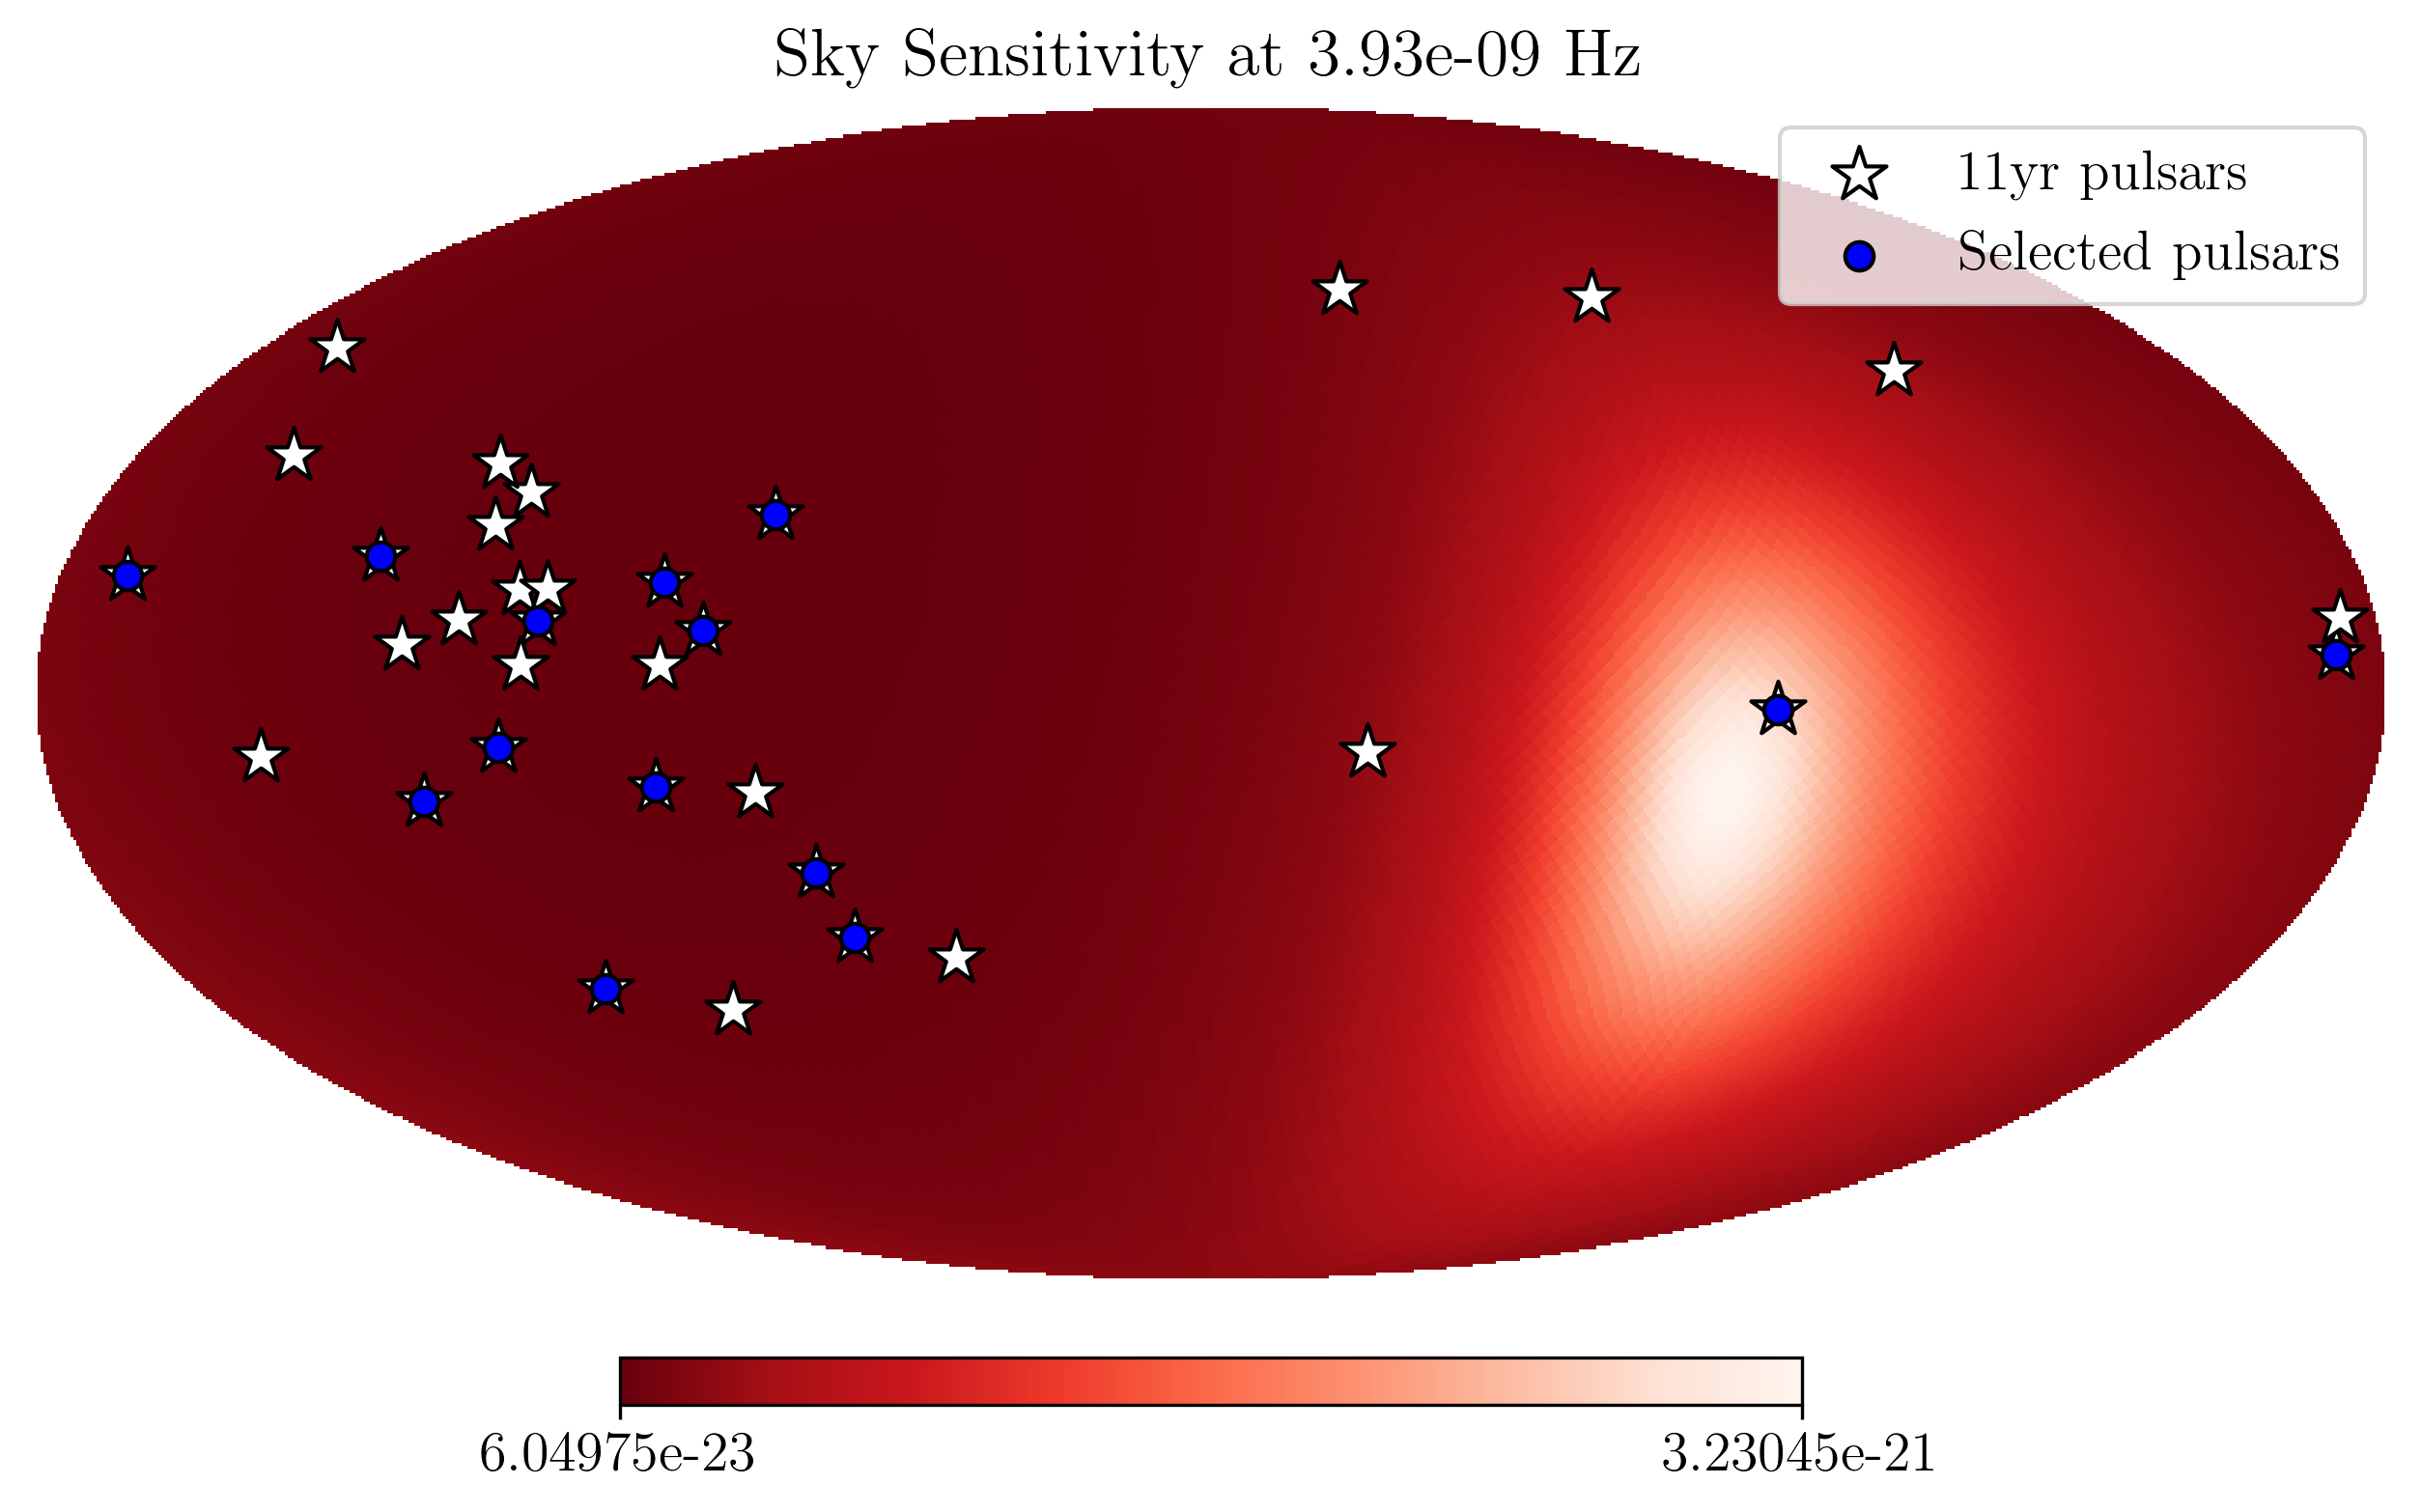

In [44]:
idxs = np.unravel_index(np.argmin(new_added_sky_map.S_effSky, axis=None),
                        new_added_sky_map.S_effSky.shape)
idx = idxs[0]
hp.mollview(new_added_sky_map.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(new_added_sky_map.freqs[idx]),
            cmap='Reds_r', rot=180)
hp.visufunc.projscatter(sky_map.thetas,sky_map.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200,label=r'11yr pulsars')
hp.visufunc.projscatter(new_added_sky_map.thetas,new_added_sky_map.phis,
                        marker='.',color='blue',
                        edgecolors='k',s=200,label=r'Selected pulsars')
plt.legend()
plt.show()

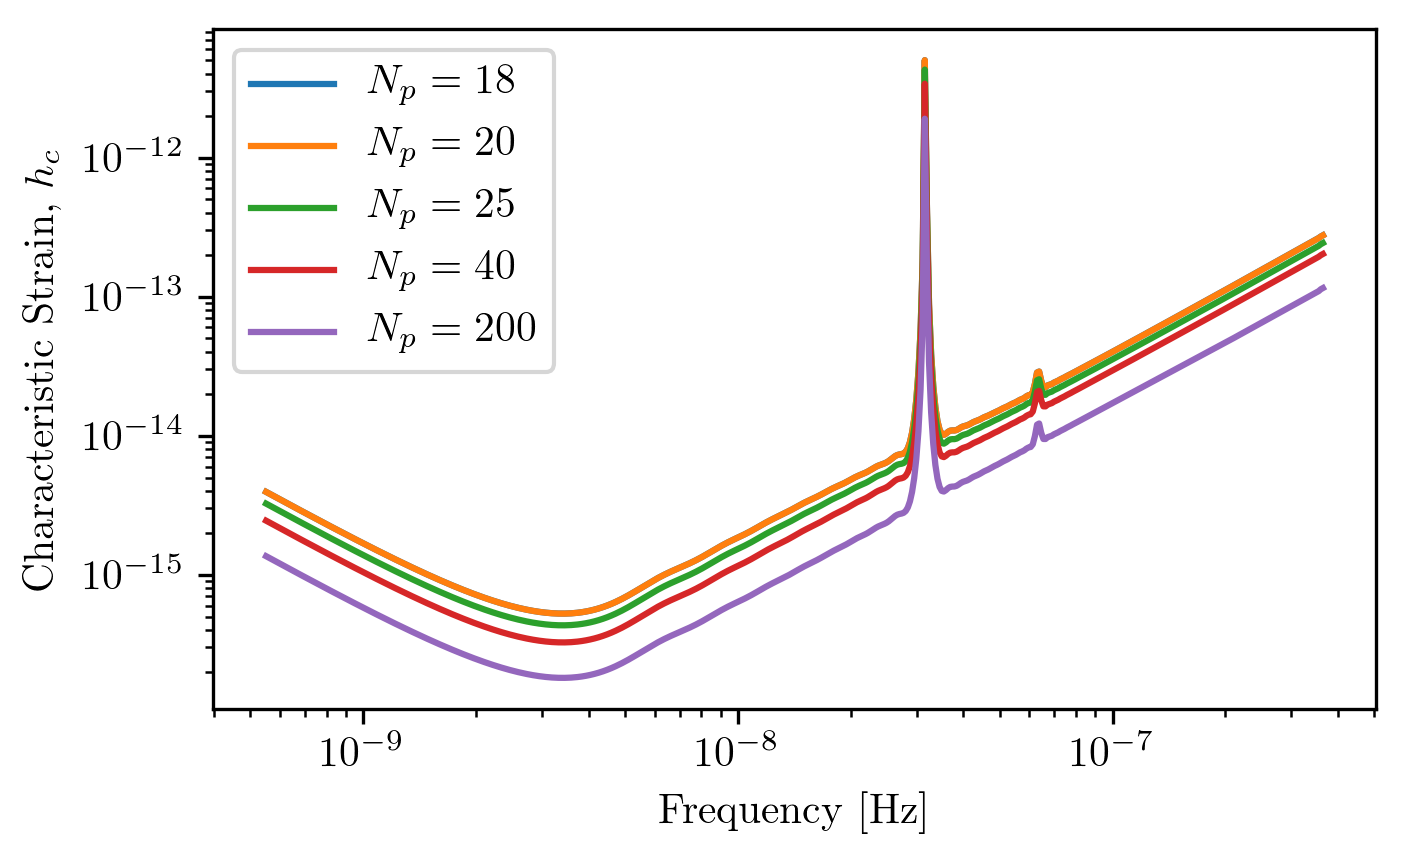

In [60]:
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':10})
N_ps = [18,20,25,40,200]
plt.figure()
for N_p in N_ps:
    if N_p > len(noise_11yr):
        N_added_p = N_p - len(noise_11yr)
        theta_draws = theta_dist.rvs(size=N_added_p)
        phi_draws = phi_dist.rvs(size=N_added_p)
        rn_amp_draws = rn_amp_dist.rvs(size=N_added_p)
        alpha_draws = alpha_dist.rvs(size=N_added_p)
        sigma_draws = sigma_dist.rvs(size=N_added_p)

        new_added_thetas = np.append(thetas,theta_draws)
        new_added_phis = np.append(phis,phi_draws)
        new_added_rn_amps = np.append(rn_amps,rn_amp_draws)
        new_added_rn_alphas = np.append(rn_alphas,alpha_draws)
        new_added_sigmas = np.append(sigmas,sigma_draws)
    else:
        new_added_thetas = thetas[:N_p]
        new_added_phis = phis[:N_p]
        new_added_rn_amps = rn_amps[:N_p]
        new_added_rn_alphas = rn_alphas[:N_p]
        new_added_sigmas = sigmas[:N_p]

    pta = make_hasasia_sensitivity_thing(T_obs,cadence,
                                         new_added_sigmas,new_added_phis,
                                         new_added_thetas,new_added_rn_amps,
                                         new_added_rn_alphas,SkyAvg=True)
    plt.loglog(pta.freqs,pta.h_c,label=r'$N_{p} = %i$' %N_p)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.legend()
plt.show()